In [1]:
import numpy as np 
import matplotlib.pyplot as plt

# install
## numpy
## matplotlib

## 문제 1) PCA using power iteration

##### 차원 축소 방법인 PCA 중 Power Iteration 알고리즘 구현

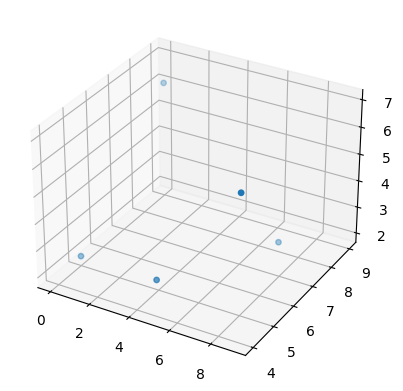

In [2]:
from mpl_toolkits.mplot3d import Axes3D as ax

X=np.random.randint(10, size=15).reshape(-1,3)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[:,0], X[:,1], X[:,2], marker='o', s=15)
plt.show()

In [3]:
def power_iteration(X, num_iter, epsilon) :

    X_centered = X - np.mean(X, axis=0)   # Data centered
    A = np.cov(X_centered, rowvar=False)  # Construct covariance matrix

    M, N = X.shape
    convert_matrix = np.zeros((N, num_iter))  # Initializing conversion matrix

    for k in range(num_iter) :    # Power iteration
      b = np.ones(N) / np.sqrt(N) # eigen vector
      while True :
        b_next = np.dot(A, b) / np.linalg.norm(np.dot(A, b))

        if np.linalg.norm(b_next - b) < epsilon :
          break

        b = b_next

      eigen_value = np.dot(b_next, np.dot(A, b_next)) # Compute eigen value
      A -= eigen_value * np.outer(b_next, b_next)     # Update A

      convert_matrix[:, k] = b_next # Save the eigen vector in Convert matrix

    return convert_matrix

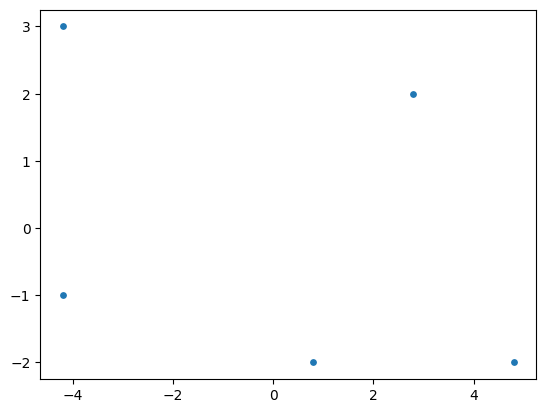

In [4]:
convert_mat = power_iteration(X, num_iter=2, epsilon=1e-10)
# nomaization (be cetered)
X = X - X.mean(axis=0)
proj_X = X.dot(convert_mat)

plt.scatter(X[:,0], X[:,1], marker='o', s=15)
plt.show()

## MNIST data load & preprocessing

##### MNIST 손글씨 데이터셋

In [5]:
from google.colab import drive
drive.mount('/content/drive')
!pwd
%cd /content/drive/MyDrive/Colab Notebooks/assign07

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content
/content/drive/MyDrive/Colab Notebooks/assign07


In [6]:
from dataset.mnist import load_mnist

(train_raw_img, train_y), (test_raw_img, test_y) = load_mnist(flatten=False, normalize=False)

In [7]:
# reshape 
train_X = train_raw_img.reshape(len(train_raw_img.squeeze()), -1)
test_X = test_raw_img.reshape(len(test_raw_img.squeeze()), -1)

# nomaization 1 (set value 0 ~ 1)
train_X = train_X.astype('float')/255
test_X = test_X.astype('float')/255

In [8]:
def visualization(proj_X, y) :
    data = proj_X[:100] # 시각화용 데이터 100개
    label = y[:100]
    
    digit_color=['C0','C1','C2','C3','C4','C5','C6','C7','C8','C9']
    for label, x, y in zip(label, data[:, 0], data[:, 1]):
        plt.annotate(label, xy=(x, y))
        plt.scatter(x,y, color=digit_color[label])

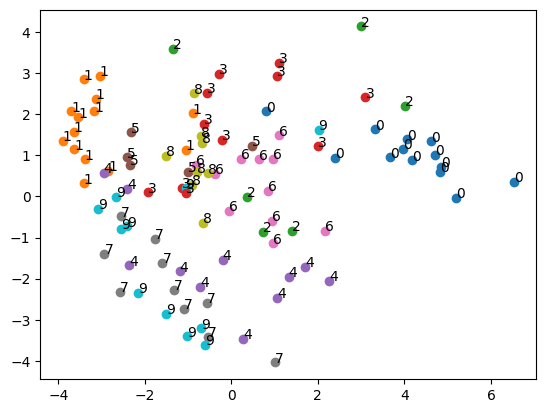

In [9]:
convert_mat = power_iteration(train_X, num_iter=2, epsilon=1e-10) # reduce to 2D
# nomaization 2 (be cetered)
train_X = train_X - train_X.mean(axis=0)
test_X = test_X - test_X.mean(axis=0)
proj_X = train_X.dot(convert_mat)

visualization(proj_X, train_y)

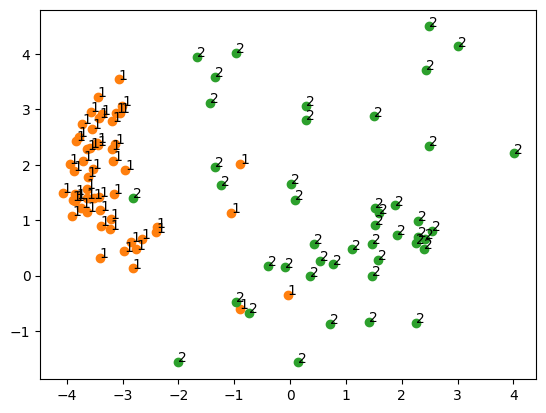

In [10]:
# 두 클래스 간의 비교를 위한 visualziation
mask = (train_y==1) | (train_y==2)
tmp_data = proj_X[mask]
tmp_label = train_y[mask]

visualization(tmp_data, tmp_label)

## 문제 2) PCA + linear model

##### data -> PCA(784, M) -> Linear(M, 10) -> Softmax(10, 10)

## model

In [11]:
# 각 layer에 대한 클래스 구현
class Linear :
    def __init__(self, input_size=1, hidden_size=1) :
        self.W = np.random.randn(input_size, hidden_size) # input_size와 hidden_size를 가지는 정규분포를 따르는 난수 생성
        self.b = np.zeros(hidden_size)
        self.x = None
        self.dW = None
        self.db = None
    
    def forward(self, x) :
        self.x = x
        out = np.dot(x, self.W) + self.b  # 입력값(x) * 가중치(W) + Bias(b)
        return out
    
    def backward(self, dout, lr, lamb=0) :
        dx = np.dot(dout, self.W.T) # 입력값에 대한 미분값
        self.dW = np.dot(self.x.T, dout)  # 가중치에 대한 미분값
        self.db = np.sum(dout, axis=0)  # Bias에 대한 미분값
        self.W -= lr * (self.dW + lamb * self.W)  # 학습률(lr)을 통해 가중치 업데이트
        self.b -= lr * self.db  # 학습률(lr)을 통해 Bias 업데이트
        return dx

In [12]:
class Softmax_with_CrossEntropy :
    def __init__(self) :
        # softmax
        self.softmax_x = None 
        self.softmax_out = None
        # crossEntropy
        self.pred = None
        self.target = None
        self.delta = 1e-7
        
    def softmax_forward(self, x) :
        self.softmax_x = x
        tmp = np.max(self.softmax_x, axis=1).reshape(-1, 1)
        self.softmax_out = np.exp(self.softmax_x-tmp)/np.sum(np.exp(self.softmax_x-tmp), axis=1).reshape(-1,1)
        return self.softmax_out
    
    def crossEntropy_forward(self, pred, target) :
        self.pred = pred
        self.target = target
        loss = -np.sum(self.target*np.log(self.pred+self.delta), axis=1)
        return loss
    
    def backward(self) :
        dout = (self.pred-self.target)/len(self.pred)
        return dout

## Train / Eval

In [13]:
# one_hot label 만드는 함수
def make_one_hot(labels) :
    a = []
    for label in labels :
        one_hot = np.zeros(10)
        one_hot[label] = 1
        a.append(one_hot)
    a = np.array(a)
    return a

In [14]:
def eval(model, convert, train_version = True) :
    if train_version :
        x = train_X
        labels = train_y.squeeze()
        print('In train dataset ... ')
    else : 
        x = test_X
        labels = test_y.squeeze()
        print('\nIn test dataset ... ')

    for layer in model.values() :
        if isinstance(layer, Softmax_with_CrossEntropy) :
            x = layer.softmax_forward(x)
        else :
            x = np.dot(x, convert)
            x = layer.forward(x)
            
    preds = x.argmax(axis=1)
    acc = np.sum(np.where(preds==labels, True, False))/len(labels)
    return acc

In [15]:
from collections import OrderedDict

def train(config) :
    lr, num_epoch = config['learning_rate'], config['num_epoch']
    M, epsilon = config['M'], config['epsilon']
    print_loss_interval = 10

    convert_matrix = power_iteration(train_X, M, epsilon)
    pca_X = np.dot(train_X, convert_matrix)
    layer = Linear(M, 10)
    softmax_layer = Softmax_with_CrossEntropy()

    chart = []
    
    for iter in range(num_epoch) :
        # forward
        x = layer.forward(pca_X)
        preds = softmax_layer.softmax_forward(x)

        #loss
        one_hot_labels = make_one_hot(train_y)
        losses = softmax_layer.crossEntropy_forward(preds, one_hot_labels)
        loss = losses.sum()/len(preds)
        
        # backward
        dL = softmax_layer.backward()
        dL = layer.backward(dL, lr)
        
        if iter == 0 or (iter+1) % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter+1, num_epoch, loss))
        
        chart.append(loss)

    model = OrderedDict()
    model['layer'] = layer
    model['softmax_layer'] = softmax_layer
    
    return model, convert_matrix, chart

In [28]:
model_10, convert_10, chart_10 = train({'learning_rate':0.1, 
                      'num_epoch':100, 
                      'M':10,
                      'epsilon':1e-4})
print('\t Accuracy :', eval(model_10, convert_10, train_version=True))
print('\t Accuracy :', eval(model_10, convert_10, train_version=False))

[epoch 1 / 100] average loss : 7.250082
[epoch 10 / 100] average loss : 5.937055
[epoch 20 / 100] average loss : 4.582278
[epoch 30 / 100] average loss : 3.481430
[epoch 40 / 100] average loss : 2.670430
[epoch 50 / 100] average loss : 2.115473
[epoch 60 / 100] average loss : 1.741642
[epoch 70 / 100] average loss : 1.486237
[epoch 80 / 100] average loss : 1.307772
[epoch 90 / 100] average loss : 1.179701
[epoch 100 / 100] average loss : 1.085322
In train dataset ... 
	 Accuracy : 0.6227

In test dataset ... 
	 Accuracy : 0.6227


In [29]:
model_100, convert_100, chart_100 = train({'learning_rate':0.1, 
                      'num_epoch':100, 
                      'M':100,
                      'epsilon':1e-4})
print('\t Accuracy :', eval(model_100, convert_100, train_version=True))
print('\t Accuracy :', eval(model_100, convert_100, train_version=False))

[epoch 1 / 100] average loss : 9.577538
[epoch 10 / 100] average loss : 8.626690
[epoch 20 / 100] average loss : 7.553546
[epoch 30 / 100] average loss : 6.554021
[epoch 40 / 100] average loss : 5.695550
[epoch 50 / 100] average loss : 4.994513
[epoch 60 / 100] average loss : 4.433715
[epoch 70 / 100] average loss : 3.984530
[epoch 80 / 100] average loss : 3.620260
[epoch 90 / 100] average loss : 3.320184
[epoch 100 / 100] average loss : 3.069234
In train dataset ... 
	 Accuracy : 0.4743

In test dataset ... 
	 Accuracy : 0.4837


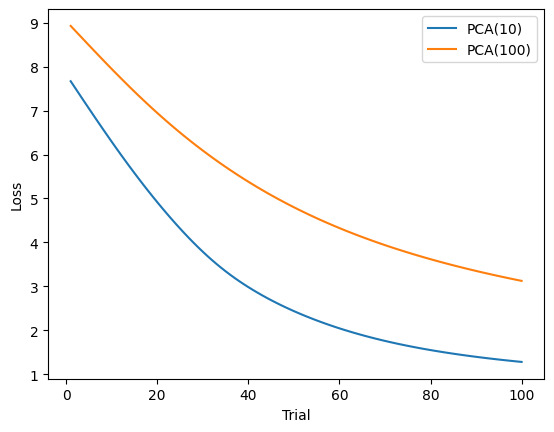

In [18]:
import matplotlib as mpl
import matplotlib.pylab as plt

y_10 = chart_10
y_100 = chart_100
x = [i for i in range(1, 101)]
plt.plot(x, y_10)
plt.plot(x, y_100)
plt.ylabel('Loss')
plt.xlabel('Trial')

plt.legend(['PCA(10)', 'PCA(100)'])

plt.show()

M = 100 일 때 보다 M = 10 일 때 loss 값이 적게 나오고, Accuracy가 더 크게 나왔다.

정확도에 영향을 주는 학습률, 반복 횟수 그리고 데이터의 전처리가 있다.학습률을 줄이고 (0.01) , 반복 횟수를 그대로 유지했을 대는 훨씬 낮은 값이 나왔다. 하지만 100회를 반복하는 데에도 많은 시간이 소요된다.

때문에 num_epoch가 100일 때 적정 학습률은 0.1이라는 것이 도출되었다.

# 심화문제) 2-layer neural network
data -> Linear (784, M) -> ReLU -> Linear (M, 10) -> softmax

In [19]:
class Relu :
    def __init__(self) :
        self.mask = None
    
    def forward(self, x) :
        self.mask = (x < 0)
        out = x.copy()
        out[self.mask] = 0
        return out
    
    def backward(self, dout) :
        dout[self.mask] = 0
        return dout                                                                                                                                                                                                                                                                                                                                                   

In [20]:
def eval_MLP(model, train_version = True) :
    if train_version :
        x = train_X
        labels = train_y.squeeze()
        print('In train dataset ... ')
    else : 
        x = test_X
        labels = test_y.squeeze()
        print('\nIn test dataset ... ')
    
    for layer in model.values() :
        if isinstance(layer, Softmax_with_CrossEntropy) :
            x = layer.softmax_forward(x)
        else :
            x = layer.forward(x)
            
    preds = x.argmax(axis=1)
    acc = np.sum(np.where(preds==labels, True, False))/len(labels)
    return acc

In [21]:
from collections import OrderedDict

def train_MLP(config) :
    lr, num_epoch = config['learning_rate'], config['num_epoch']
    M = config['M']
    print_loss_interval = 10
    
    layer1 = Linear(784, M)
    relu = Relu()
    layer2 = Linear(M, 10)
    softmax_with_CE = Softmax_with_CrossEntropy()

    chart = []
    
    for iter in range(num_epoch) :
        # forward
        x = layer1.forward(train_X)
        x = relu.forward(x)
        x = layer2.forward(x)
        preds = softmax_with_CE.softmax_forward(x)
        
        # loss
        one_hot_labels = make_one_hot(train_y)
        losses = softmax_with_CE.crossEntropy_forward(preds, one_hot_labels)
        loss = losses.sum()/len(preds)
        
        # backward
        dL = softmax_with_CE.backward()
        dL = layer2.backward(dL, lr)
        dL = relu.backward(dL)
        dL = layer1.backward(dL, lr)
        
        if iter == 0 or (iter+1) % print_loss_interval == 0:
            print("[epoch %d / %d] average loss : %f" % (iter+1, num_epoch, loss))
        
        chart.append(loss)

    model = OrderedDict()
    model['layer1'] = layer1
    model['relu'] = relu
    model['layer2'] = layer2
    model['softmax_with_CE'] = softmax_with_CE
    
    return model, chart

In [25]:
model_10_MLP, chart_10_MLP = train_MLP({'learning_rate':0.1, 
                      'num_epoch':100, 
                      'M':10, })
print('\t Accuracy :', eval_MLP(model_10_MLP, train_version=True))
print('\t Accuracy :', eval_MLP(model_10_MLP, train_version=False))

[epoch 1 / 100] average loss : 13.052148
[epoch 10 / 100] average loss : 8.057360
[epoch 20 / 100] average loss : 5.247812
[epoch 30 / 100] average loss : 3.817488
[epoch 40 / 100] average loss : 2.987432
[epoch 50 / 100] average loss : 2.479413
[epoch 60 / 100] average loss : 2.158547
[epoch 70 / 100] average loss : 1.942946
[epoch 80 / 100] average loss : 1.788721
[epoch 90 / 100] average loss : 1.673448
[epoch 100 / 100] average loss : 1.584735
In train dataset ... 
	 Accuracy : 0.5601

In test dataset ... 
	 Accuracy : 0.5698


In [26]:
model_100_MLP, chart_100_MLP = train_MLP({'learning_rate':0.1, 
                      'num_epoch':100, 
                      'M':100, })
print('\t Accuracy :', eval_MLP(model_100_MLP, train_version=True))
print('\t Accuracy :', eval_MLP(model_100_MLP, train_version=False))

[epoch 1 / 100] average loss : 13.616484
[epoch 10 / 100] average loss : 7.774167
[epoch 20 / 100] average loss : 5.494844
[epoch 30 / 100] average loss : 4.412132
[epoch 40 / 100] average loss : 3.818457
[epoch 50 / 100] average loss : 3.435185
[epoch 60 / 100] average loss : 3.161706
[epoch 70 / 100] average loss : 2.951339
[epoch 80 / 100] average loss : 2.780713
[epoch 90 / 100] average loss : 2.637990
[epoch 100 / 100] average loss : 2.515933
In train dataset ... 
	 Accuracy : 0.7947833333333333

In test dataset ... 
	 Accuracy : 0.8054


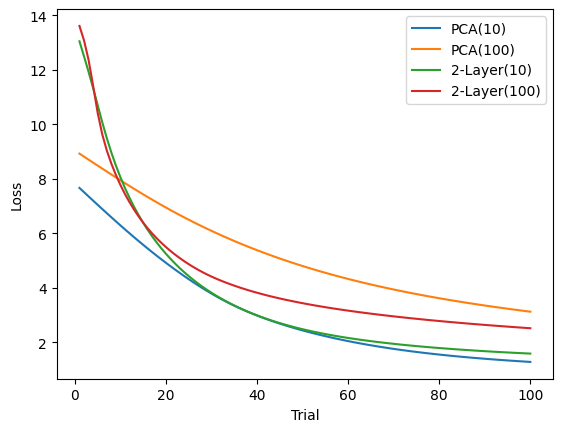

In [27]:
import matplotlib as mpl
import matplotlib.pylab as plt

y_10 = chart_10
y_100 = chart_100
y_10_M = chart_10_MLP
y_100_M = chart_100_MLP
x = [i for i in range(1, 101)]
plt.plot(x, y_10)
plt.plot(x, y_100)
plt.plot(x, y_10_M)
plt.plot(x, y_100_M)
plt.ylabel('Loss')
plt.xlabel('Trial')

plt.legend(['PCA(10)', 'PCA(100)', '2-Layer(10)', '2-Layer(100)'])

plt.show()

2-layer Neural Network의 초반 Average Loss가 높지만, Trial이 증가할 수록 Loss가 감소하는 추세가 크다

PCA를 사용하면 입력 데이터의 차원을 축소하기 때문에 M 값이 작은 경우 PCA를 통해 축소된 차원이 더 의미 있는 정보를 담아 정확도가 높다

2-layer Neural Network는 더 복잡한 모델 구조를 가져, M이 커질 수록 정확도가 증가한다.

따라서 M 값에 따라 PCA + 1-layer Neural Network와 2-layer Nerual Network 사이를 잘 선택해야 된다는 것을 알 수 있다